## Discriminative Learning and Support Vector Machines

In [125]:
import yfinance as yf
import talib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

## Data and Preprocessing

### Q1

In [126]:
data = yf.download('MSFT')
# Fix MultiIndex Problem
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

[*********************100%***********************]  1 of 1 completed


### Q2

In [127]:
# Create lagged price and volume columns (t-1)
data['High_lag1'] = data['High'].shift(1)
data['Low_lag1'] = data['Low'].shift(1)
data['Close_lag1'] = data['Close'].shift(1)
data['Volume_lag1'] = data['Volume'].shift(1)

# Bollinger Bands on lagged Close price (timeperiod=20)
upper, middle, lower = talib.BBANDS(data['Close_lag1'], timeperiod=20)
data['BB_upper'] = upper
data['BB_middle'] = middle
data['BB_lower'] = lower

# RSI on lagged Close price (timeperiod=14)
data['RSI_14'] = talib.RSI(data['Close_lag1'], timeperiod=14)

# MACD on lagged Close price (fast=12, slow=26, signal=9)
macd, signal, hist = talib.MACD(data['Close_lag1'], fastperiod=12, slowperiod=26, signalperiod=9)
data['MACD'] = macd
data['MACD_signal'] = signal
data['MACD_hist'] = hist

# Momentum on lagged Close price (timeperiod=12)
data['Momentum_12'] = talib.MOM(data['Close_lag1'], timeperiod=12)

# OBV using lagged Close price and lagged Volume
data['OBV'] = talib.OBV(data['Close_lag1'], data['Volume_lag1'])

# ATR using lagged High, Low, Close (timeperiod=14)
data['ATR_14'] = talib.ATR(data['High_lag1'], data['Low_lag1'], data['Close_lag1'], timeperiod=14)

# Continuously compounded returns of Open price
data['cc_return_open'] = np.log(data['Open'] / data['Open'].shift(1))

# CCI using lagged High, Low, Close (timeperiod=14)
data['CCI_14'] = talib.CCI(data['High_lag1'], data['Low_lag1'], data['Close_lag1'], timeperiod=14)

# Drop NaN rows caused by lagging and indicator calculations
data.dropna(inplace=True)

### Q3

In [128]:
data['Returns'] = data['Close'].pct_change()
conditions = [
    data['Returns'] >= 0.01,
    data['Returns'] <= -0.01
]
choices = [1, -1]
data['Label'] = np.select(conditions, choices, default=0)

### Q4

In [129]:
# Columns to exclude from features
exclude_cols = ['Label', 'Returns', 'Open', 'Close', 'Volume', 'High', 'Low', 'Dividends', 'Stock Splits']
# Create feature space X by dropping the excluded columns
X = data.drop(columns=exclude_cols, errors='ignore')
y = data['Label']

### Q5

In [130]:
# Split X and y into training and testing
X_train = X.iloc[:-30]
X_test = X.iloc[-30:]

y_train = y.iloc[:-30]
y_test = y.iloc[-30:]

# Apply MinMaxScaler
scaler = MinMaxScaler()

# Fit on training data, then transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using training set scaler
X_test_scaled = scaler.transform(X_test)

## Discriminative Learning

### Q6

In [131]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10]
}

# TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5, test_size=1, gap=0)

# Logistic Regression model with liblinear solver
LogisticRegression(solver='liblinear')
lr = LogisticRegression(solver='liblinear', max_iter=1000)

# Grid search using time series cross-validation
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1
)

# Fit grid search on training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_

# Train a model using best parameters
best_logistic_model = grid_search.best_estimator_

# Accuracy on training and test data
train_accuracy = accuracy_score(y_train, best_logistic_model.predict(X_train_scaled))
test_accuracy = accuracy_score(y_test, best_logistic_model.predict(X_test_scaled))

# Report
print("Best Parameters:", best_params)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Best Parameters: {'C': 0.1, 'penalty': 'l1'}
Training Accuracy: 0.5077
Test Accuracy: 0.6333


## Support Vector Machine

### Q7

In [132]:
# 1. Define the parameter distribution
param_dist = {
    'C': [0.3, 0.5, 1, 5, 10, 20, 30, 50, 100],
    'kernel': ['linear', 'rbf']
}

# 2. Create the time series cross-validator
tscv = TimeSeriesSplit(n_splits=5, test_size=1, gap=0)

# 3. Initialize the SVM classifier
svm = SVC()
svm = SVC(class_weight='balanced')

# 4. Setup randomized search
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=10,  # or len of full grid if you want exhaustive search
    cv=tscv,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42
)

# 5. Fit on training data
random_search.fit(X_train_scaled, y_train)

# 6. Best parameters
best_params = random_search.best_params_

best_svm_model = random_search.best_estimator_

# 7. Predict on test set
y_pred = random_search.predict(X_test_scaled)

# 8. Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# 9. Report
print("Best Parameters:", best_params)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision (macro): {precision:.4f}")
print(f"Test Recall (macro): {recall:.4f}")

Best Parameters: {'kernel': 'linear', 'C': 10}
Test Accuracy: 0.2000
Test Precision (macro): 0.1705
Test Recall (macro): 0.3409


### Q8

In [133]:
# Predict using trained logistic regression model
logistic_preds = best_logistic_model.predict(X_test_scaled)

# Predict using trained SVM model
svm_preds = best_svm_model.predict(X_test_scaled)

In [134]:
# Strategy returns: multiply predicted label by actual return
data_test = data.iloc[-len(y_test):].copy()
data_test['Logistic_Returns'] = pd.Series(logistic_preds, index=data_test.index).shift(1) * data_test['Returns']
data_test['SVM_Returns'] = pd.Series(svm_preds, index=data_test.index).shift(1) * data_test['Returns']

# Buy-and-hold (market) returns
data_test['Market_Returns'] = data_test['Returns']

In [135]:
data_test['Logistic_Cumulative'] = (1 + data_test['Logistic_Returns']).cumprod()
data_test['SVM_Cumulative'] = (1 + data_test['SVM_Returns']).cumprod()
data_test['Market_Cumulative'] = (1 + data_test['Market_Returns']).cumprod()

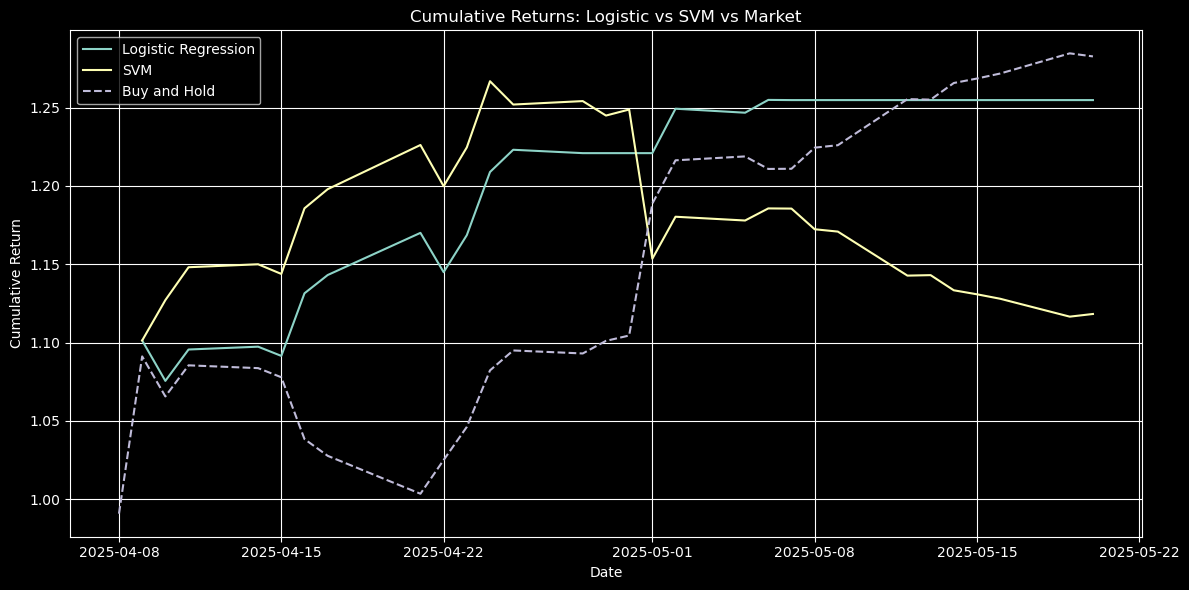

In [136]:
plt.figure(figsize=(12,6))
plt.plot(data_test.index, data_test['Logistic_Cumulative'], label='Logistic Regression')
plt.plot(data_test.index, data_test['SVM_Cumulative'], label='SVM')
plt.plot(data_test.index, data_test['Market_Cumulative'], label='Buy and Hold', linestyle='--')

plt.title('Cumulative Returns: Logistic vs SVM vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 From the graph, we can see that the logistic regression method prevails most of the times. 



And before the 2025-05-01, the logictic regression method leads all of 3 and better than SVM, Buy and hold method. But after that, SVM method drops drastically. This is probably because the test data starts at 2025-04-07, and the SVM method overfits the train data so if the market regime shifted in early May ( volatility spike, macro news, etc.), SVM could have made systematically poor predictions.
 Logistic Regression consistently outperforms both the SVM and Buy and Hold strategies, reaching a cumulative return of 1.26 by mid-May 2025, and this is due to Logistic regression is simpler and less prone to overfitting, especially on financial data that is noisy, non-stationary and subject to random shock.

### Q9
Do you think these results are dependent on the cross-validation method and scoring? Do
you think that if you change the scoring method you would get different results?

Yes, the results are very likely dependent on the cross-validation (CV) method and the scoring metric, especially for a task like financial forecasting where the cost of wrong predictions varies significantly.

Dependcence on CV method: Random (stratified) k-fold vs. time-series split: If we use ordinary StratifiedKFold, we are future reading in each fold whenever there’s any serial correlation. A time-series split (where each fold respects chronological order) can yield very different hyperparameter choices—often more conservative ones—especially in a non-stationary domain like equities. Number of folds, shuffle, stratification: Fewer folds → higher variance in the performance estimate; Shuffling → breaks any local clustering of rare events

Dependence on the scoring metric: the f1 score: This metric equally weights each class’s F1 score, so the search will favor models that balance precision and recall across both “up” and “down,” even if one class is rare. For the accuracy: the model would favor the majority class, potentially over-fitting to “no-move” or whatever class is largest. For the precision and recall, the model bias toward fewer false positives or fewer false negatives, respectively. And finally for the ROC-AUC, we get the hyperparameters that maximize separation of positive vs. negative scores, but might sacrifice calibration.